##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning with a pretrained ConvNet

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os

%matplotlib inline

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

print(tf.__version__)
# tf.debugging.set_log_device_placement(True)

TensorFlow 2.x selected.
2.1.0


## Data preprocessing

### Data download

Use following commands to download [Freiburg Groceries Dataset](http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/).

It consists of ~5,000~ 4,947 images covering 25 different classes of groceries, with at least 97 images per class.

Each image is `256x256x3`.

In [0]:
# !pwd
# !ls
# !rm -rf images
# !tar -xf dataset07.tar.gz
# !ls


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [0]:
data_dir = pathlib.Path('./images')

train_data_dir = pathlib.Path('./images/train/')
test_data_dir = pathlib.Path('./images/test/')

In [0]:
# # https://github.com/PhilJd/freiburg_groceries_dataset/
# data_dir = tf.keras.utils.get_file(
#     # origin='http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz',
#     origin='https://drive.google.com/uc?export=download&confirm=h06G&id=1_H296yVPEITalCMxOoGJ332shOd4_6Dx',
#     fname='dataset01', 
#     untar=True)
# data_dir = pathlib.Path(data_dir)

# train_data_dir = pathlib.Path('./images/train/')
# test_data_dir = pathlib.Path('./images/test/')

# DATASET_SIZE = len(list(data_dir.glob('*/*.png')))
DATASET_SIZE = len(list(data_dir.glob('train/*/*.jpeg')))
print(DATASET_SIZE)

CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*')])
print(CLASS_NAMES, len(CLASS_NAMES))

10000
['LEMON' 'MELON' 'BANANA' 'TOMATO' 'PEACH' 'OIL' 'CABBAGE' 'WATERMELON'
 'LEEK' 'PEPPER_GREEN' 'SUGAR' 'APPLE_GREEN' 'PINEAPPLE' 'ORANGE' 'JAM'
 'POTATO' 'MILK' 'PEPPER_RED' 'EGGPLANT' 'POMEGRANATE' 'ASPARAGUS'
 'TOMATO_SAUCE' 'ONION' 'CHICKPEAS' 'PLUM' 'PEAR' 'AVOCADO' 'EGGS'
 'ZUCCHINI' 'MUSHROOM' 'GARLIC' 'CARROTS' 'CUCUMBER' 'KIWI' 'FLOUR' 'CORN'
 'APPLE_RED' 'PASTA' 'RICE' 'BEANS'] 40


In [0]:
BATCH_SIZE = 64 #32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(DATASET_SIZE/BATCH_SIZE)

AUTOTUNE = tf.data.experimental.AUTOTUNE

(275, 183, 3)


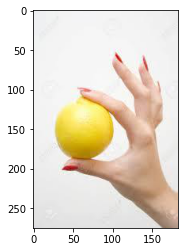

In [0]:
im=Image.open(list(train_data_dir.glob('*/*.jpeg'))[0]).convert('RGB')
im = np.asarray(im) 
print(im.shape)
plt.imshow(im)

In [0]:
# list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
# list_ds = list_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'), shuffle=False)

for f in train_list_ds.take(5):
  print(f.numpy())

b'images/train/PEAR/pear_0168.jpeg'
b'images/train/AVOCADO/avocado_0114.jpeg'
b'images/train/POMEGRANATE/pomegranate_0037.jpeg'
b'images/train/LEEK/leek_0185.jpeg'
b'images/train/PEACH/peach_0061.jpeg'


### Preprocessing data

Read the data using the `tf.io.read_file` function and extract the label from the path, returning `(image, label)` pairs:

The `Dataset.map(f)` transformation produces a new dataset by applying a given function f to each element of the input dataset.

In [0]:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/guide/data#consuming_sets_of_files

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
for image, label in labeled_train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

labeled_train_ds.element_spec

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False]


(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(40,), dtype=tf.bool, name=None))

### Data augmentation

In [0]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-20, 20), reshape=False)
  return image

def augment(image,label):
  # image,label = convert(image, label)
  # image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  px = np.random.randint(3, 10)
  image = tf.image.resize_with_crop_or_pad(image, IMG_WIDTH+px, IMG_HEIGHT+px) # Add px pixels of padding

  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])

  image = tf.image.random_crop(image, size=[IMG_WIDTH, IMG_HEIGHT, 3]) # Random crop back
  image = tf.image.random_brightness(image, max_delta=0.05) # Random brightness
  image = tf.image.random_saturation(image, lower=0.75, upper=1.25)
  image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
  image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_flip_up_down(image)

  # im_shape = image.shape
  # [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  # image.set_shape(im_shape)

  return image,label

## Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  # The augmentation is added here.
  ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(64, 224, 224, 3)


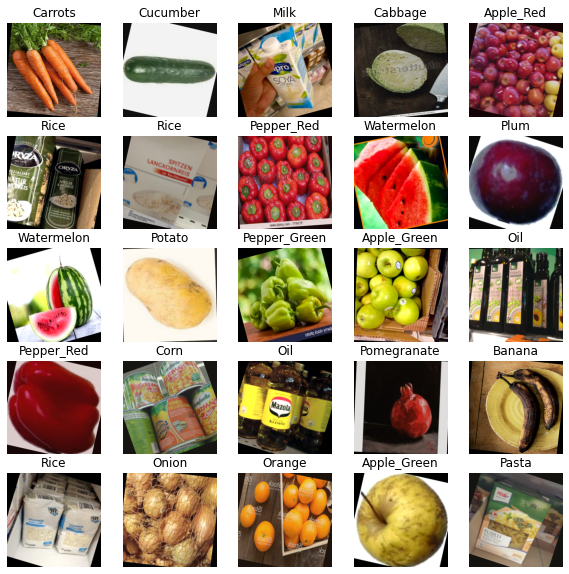

In [0]:
train_ds = prepare_for_training(labeled_train_ds)
# train_ds = train_ds.map(prepare_for_training, num_parallel_calls=AUTOTUNE)

# val_ds = val_ds.batch(BATCH_SIZE)
test_ds = labeled_test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())
print(image_batch.shape)

## Performance


In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [0]:
# `tf.data`
timeit(train_ds)

# Without cache:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

# If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:
# filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
# timeit(filecache_ds)


Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
....................................................................................................
1000 batches: 19.880054712295532 s
1609.65352 Images/s
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
....................................................................................................
1000 batches: 101.06005811691284 s
316.64340 Images/s


## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [0]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNetV2
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, # default is 224x224x3
                                               include_top=False,
                                               weights='imagenet')
                                               

94674944/94668760 [==============================] - 1s 0us/step


This feature extractor converts each `224x224x3` image into a `7x7x1280` block of features. See what it does to the example batch of images:


In [0]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [0]:
base_model.trainable = False

In [0]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `7x7` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [0]:
prediction_layer = tf.keras.layers.Dense(25)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 25)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(), # global_average_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(len(CLASS_NAMES)), # prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [0]:
base_learning_rate = 0.0001
model.compile(# optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
re_lu_3 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

The 2.5M parameters in MobileNet are frozen, but there are 32K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [0]:
len(model.trainable_variables)

8

### Train the model

After training for 10 epochs, ~you should see ~96% accuracy.~

Let us train for 50 epochs in 3 phases:

* First, only the classification head, (17 epochs)
* Secondly using fine tuning, unfreezing some layers of the pre-trained model, (17 epochs)
* Finally, with the hole model (16 epochs)


In [0]:
validation_steps=None # 20

loss1,accuracy1 = model.evaluate(test_ds, 
                                 steps = validation_steps 
                                 )

3/3 [==============================] - 1s 388ms/step - loss: 3.3321 - accuracy: 0.3091


In [0]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.88
initial accuracy: 0.02


In [0]:
initial_epochs = 17

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_ds
                    )

Train for 130.0 steps, validate for 33 steps
Epoch 1/10
130/130 [==============================] - 211s 2s/step - loss: 3.8333 - accuracy: 0.0306 - val_loss: 3.6511 - val_accuracy: 0.0848
Epoch 2/10
130/130 [==============================] - 182s 1s/step - loss: 3.6559 - accuracy: 0.0482 - val_loss: 3.4376 - val_accuracy: 0.1896
Epoch 3/10
130/130 [==============================] - 182s 1s/step - loss: 3.4911 - accuracy: 0.0906 - val_loss: 3.0215 - val_accuracy: 0.2325
Epoch 4/10
130/130 [==============================] - 182s 1s/step - loss: 3.2534 - accuracy: 0.1367 - val_loss: 2.7099 - val_accuracy: 0.2602
Epoch 5/10
130/130 [==============================] - 182s 1s/step - loss: 3.0051 - accuracy: 0.1835 - val_loss: 2.4094 - val_accuracy: 0.3182
Epoch 6/10
130/130 [==============================] - 179s 1s/step - loss: 2.7983 - accuracy: 0.2244 - val_loss: 2.1961 - val_accuracy: 0.3631
Epoch 7/10
130/130 [==============================] - 177s 1s/step - loss: 2.6110 - accuracy: 0.2

In [0]:
# more_epochs = 40
# total_epochs =  initial_epochs + more_epochs

# history_more = model.fit(train_ds,
#                          epochs=total_epochs,
#                          initial_epoch = initial_epochs,
#                          steps_per_epoch=STEPS_PER_EPOCH,
#                          validation_data=test_ds)

Train for 130.0 steps, validate for 33 steps
Epoch 11/50
130/130 [==============================] - 191s 1s/step - loss: 2.1577 - accuracy: 0.3815 - val_loss: 1.7025 - val_accuracy: 0.4946
Epoch 12/50
130/130 [==============================] - 181s 1s/step - loss: 2.0779 - accuracy: 0.3910 - val_loss: 1.6573 - val_accuracy: 0.4976
Epoch 13/50
130/130 [==============================] - 180s 1s/step - loss: 2.0037 - accuracy: 0.4157 - val_loss: 1.6064 - val_accuracy: 0.5171
Epoch 14/50
130/130 [==============================] - 179s 1s/step - loss: 1.9349 - accuracy: 0.4331 - val_loss: 1.6188 - val_accuracy: 0.5156
Epoch 15/50
130/130 [==============================] - 183s 1s/step - loss: 1.8693 - accuracy: 0.4434 - val_loss: 1.5540 - val_accuracy: 0.5331
Epoch 16/50
130/130 [==============================] - 181s 1s/step - loss: 1.7937 - accuracy: 0.4721 - val_loss: 1.5637 - val_accuracy: 0.5356
Epoch 17/50
130/130 [==============================] - 182s 1s/step - loss: 1.7661 - accura

In [0]:
!mkdir -p saved_model
# Save the entire model to a HDF5 file.
model.save('saved_model/my_model.h5')

# # Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('saved_model/my_model.h5')

# # Show the model architecture
# new_model.summary()

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

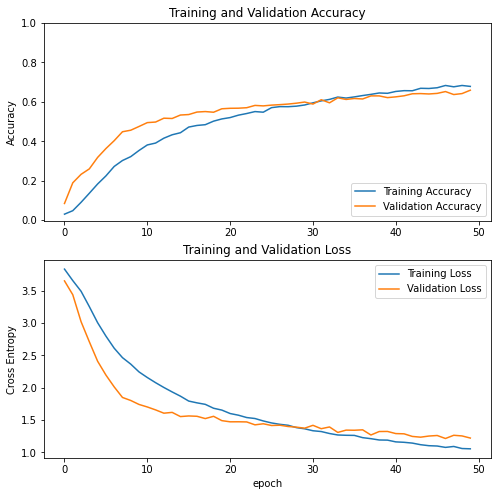

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  190


### Compile the model

Compile the model using a much lower learning rate.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

In [0]:
len(model.trainable_variables)

90

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [0]:
fine_tune_epochs = 17
total_epochs =  initial_epochs + fine_tune_epochs #+ more_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch =  initial_epochs ,#+ more_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_data=test_ds)

Train for 130.0 steps, validate for 33 steps
Epoch 11/20
130/130 [==============================] - 203s 2s/step - loss: 1.0171 - accuracy: 0.6978 - val_loss: 0.8216 - val_accuracy: 0.7446
Epoch 12/20
130/130 [==============================] - 187s 1s/step - loss: 0.9249 - accuracy: 0.7212 - val_loss: 0.8219 - val_accuracy: 0.7490
Epoch 13/20
130/130 [==============================] - 189s 1s/step - loss: 0.8659 - accuracy: 0.7364 - val_loss: 0.7942 - val_accuracy: 0.7549
Epoch 14/20
130/130 [==============================] - 187s 1s/step - loss: 0.7864 - accuracy: 0.7593 - val_loss: 0.7912 - val_accuracy: 0.7607
Epoch 15/20
130/130 [==============================] - 188s 1s/step - loss: 0.7749 - accuracy: 0.7684 - val_loss: 0.7553 - val_accuracy: 0.7724
Epoch 16/20
130/130 [==============================] - 188s 1s/step - loss: 0.7223 - accuracy: 0.7827 - val_loss: 0.7787 - val_accuracy: 0.7680
Epoch 17/20
130/130 [==============================] - 188s 1s/step - loss: 0.7084 - accura

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

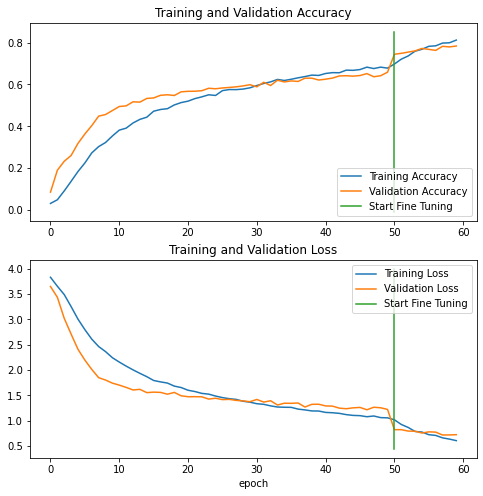

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs, initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs, initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Un-freeze the hole model

In [0]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
        )

In [0]:
more_epochs = 16
total_epochs =  initial_epochs + fine_tune_epochs + more_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch =  initial_epochs + fine_tune_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_data=test_ds)

In [0]:
acc += history_more.history['accuracy']
val_acc += history_more.history['val_accuracy']

loss += history_more.history['loss']
val_loss += history_more.history['val_loss']

model.save('saved_model/my_model.h5')

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs + fine_tune_epochs, initial_epochs + fine_tune_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs + fine_tune_epochs, initial_epochs + fine_tune_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


In [0]:
!unzip Photos.zip

Archive:  Photos.zip
  inflating: IMG_20200321_181344.jpg  
  inflating: IMG_20200321_181521.jpg  
  inflating: IMG_20200321_181528.jpg  
  inflating: IMG_20200321_181524.jpg  
  inflating: IMG_20200321_181538.jpg  


(3000, 3000, 3)


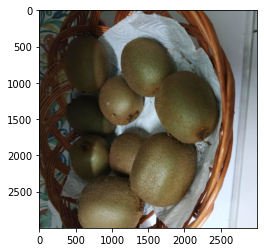

In [0]:
# img=Image.open('IMG_20200321_181344.jpg').convert('RGB')
img=Image.open('kiwi.jpeg').convert('RGB')
img = np.asarray(img) 
print(img.shape)
plt.imshow(img)

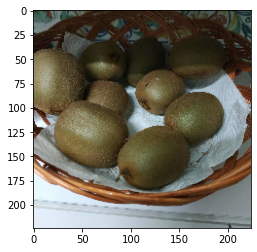

['EGGS']


In [0]:
img = tf.io.read_file('kiwi.jpeg')
img = decode_img(img)
img = tf.image.rot90(tf.image.rot90(tf.image.rot90(img)))
plt.imshow(img)
plt.show()
# model.predict(tf.expand_dims(img, 0))
c = model.predict_classes(tf.expand_dims(img, 0))
print(CLASS_NAMES[c])

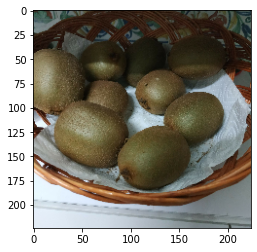

['EGGS']


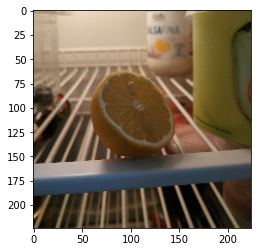

['LEMON']


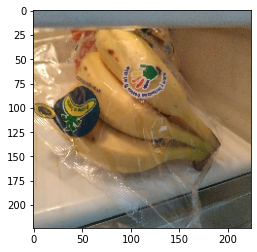

['FLOUR']


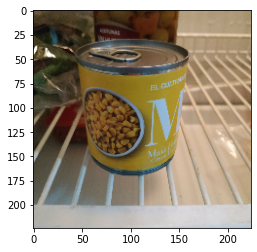

['CHICKPEAS']


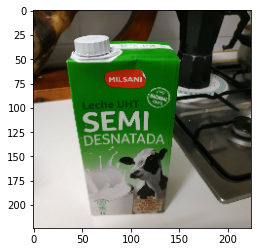

['MILK']


In [0]:
# imgs = []
for f in ['IMG_20200321_181344.jpg', 'IMG_20200321_181521.jpg', 'IMG_20200321_181528.jpg', 'IMG_20200321_181524.jpg', 'IMG_20200321_181538.jpg']:
  img = tf.io.read_file(f)
  img = decode_img(img)
  img = tf.image.rot90(tf.image.rot90(tf.image.rot90(img)))
  plt.imshow(img)
  plt.show()
  # model.predict(tf.expand_dims(img, 0))
  c = model.predict_classes(tf.expand_dims(img, 0))
  print(CLASS_NAMES[c])

In [0]:
# test_imgs, test_class = test_ds
# image_batch, label_batch = next(iter(train_ds))
labels=[]
preds=[]
for image_batch, label_batch in test_ds:
  proto_tensor = tf.make_tensor_proto((tf.argmax(tf.cast(label_batch, tf.int8), axis=-1)))  # convert `tensor a` to a proto tensor
  
  labels.append(tf.make_ndarray(proto_tensor))
  preds.append(model.predict_classes(image_batch))

In [0]:
(preds[0]), labels[0]

(array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  3, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        37, 37, 37, 37, 11, 37, 11, 37, 11, 37, 11, 11, 37]),
 array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]))

In [0]:
preds = np.hstack(preds)
labels=np.hstack(labels)

In [0]:
cm = tf.math.confusion_matrix(labels=labels, predictions=preds, num_classes=42)
cm

<tf.Tensor: shape=(42, 42), dtype=int32, numpy=
array([[29,  1,  0, ...,  0,  0,  0],
       [ 0, 49,  0, ...,  0,  0,  0],
       [ 0,  0, 57, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 39,  0,  0],
       [ 0,  0,  0, ...,  1, 28,  0],
       [ 0,  0,  0, ...,  1,  0, 43]], dtype=int32)>

In [0]:
import itertools

def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  # return figure

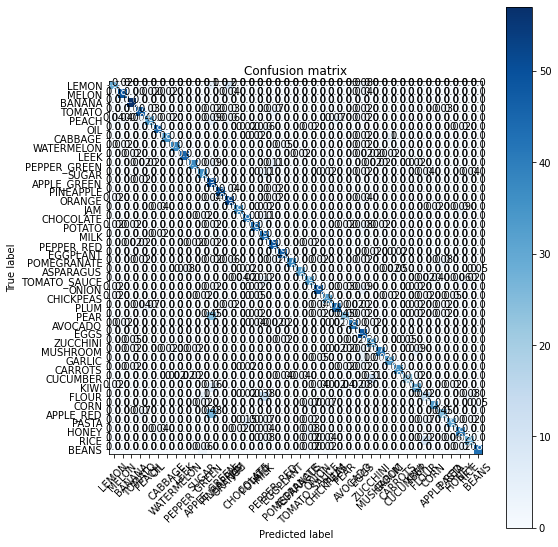

In [0]:
proto_cm = tf.make_tensor_proto(cm)  # convert `tensor a` to a proto tensor
cm = tf.make_ndarray(proto_cm)

plot_confusion_matrix(cm, class_names=CLASS_NAMES)

In [0]:
with np.printoptions(threshold=np.inf):
    print(cm)
# print(cm)

[[29  1  0  0  0  0  0  0  0  0  0  5  0 10  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  1  0  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 47  2  0  0  0  0  0  0  1  0  2  0  0  0  0  4  0  0  0  0  0
   0  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 2  2  0  2 34  0  1  0  0  0  0  5  0  3  0  0  0  0  0  0  0  0  0  0
   0  4  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  1  0  3  0  0  0  0  1  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0  0  1  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  